In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [ ]:
import tensorflow as tf
from cv2 import cv2
import sys
import os
import time
import math
import numpy as np
from tqdm import tqdm
from glob import glob

# Download dataset to google colab instance

In [ ]:
!wget --no-check-certificate --no-clobber https://raw.githubusercontent.com/Karenw1004/Deeppicar-v3/main/Dataset.zip

--2021-01-28 18:23:55--  https://raw.githubusercontent.com/Karenw1004/Deeppicar-v3/main/Dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69313921 (66M) [application/zip]
Saving to: ‘Dataset.zip’

Dataset.zip         100%[===================>]  66.10M   104MB/s    in 0.6s    

2021-01-28 18:23:57 (104 MB/s) - ‘Dataset.zip’ saved [69313921/69313921]



In [ ]:
import zipfile

list_zip = glob("./*.zip")
print(list_zip)
local_zip_file_path = list_zip[0]
print(local_zip_file_path)

zip_ref = zipfile.ZipFile(local_zip_file_path)
data_dir = local_zip_file_path.replace(".zip","")
print(data_dir)
zip_ref.extractall(data_dir)
print("The Dataset folder has been added to the colab instance")

['./Dataset.zip']
./Dataset.zip
./Dataset
The Dataset folder has been added to the colab instance


In [ ]:
!git update-index --assume-unchanged ./Dataset/

fatal: not a git repository (or any of the parent directories): .git


# Preprocess dataset video to frames

In [ ]:
# Config
NFRAMES = 1000

img_height = 66
img_width =  200
img_channels = 3
input_shape = [ img_height, img_width, img_channels]

In [ ]:
!mkdir $data_dir/train_images

In [ ]:
for i in tqdm(range(11)):
  
  # Open the video file
  vid_path = f"out-video-{i}"
  vid_ext = ".avi"
  path = data_dir + "/" + vid_path + vid_ext
  assert os.path.isfile(path)
  cap = cv2.VideoCapture(path)

  curFrame = 0

  while (cap.isOpened()):
    if curFrame < NFRAMES:
      cam_start = time.time()
      ret, img = cap.read()

      if cv2.waitKey(1) & 0xFF == ord('q'):
        break

      curFrame += 1
      filename = f"train_images/{vid_path}_frame_{curFrame}.jpg" 
      frame = img
      cv2.imwrite(f"{data_dir}/{filename}", frame)

    else:
      break

cap.release()
cv2.destroyAllWindows()

100%|██████████| 11/11 [00:22<00:00,  2.04s/it]


# Load the images and categorize image

In [ ]:
from glob import glob
import pandas as pd

all_csv_files = glob("./Dataset/*.csv")
df_dict = {}
print(all_csv_files)
for filepath in all_csv_files:
  df = pd.read_csv(filepath, index_col=None,header=0)
  filename = filepath.split("/")[-1]
  out_number = filename.split("-")[-1]
  out_number = int(out_number.split(".")[0])
  df_dict[out_number] = df

['./Dataset/out-key-0.csv', './Dataset/out-key-2.csv', './Dataset/out-key-3.csv', './Dataset/out-key-6.csv', './Dataset/out-key-9.csv', './Dataset/out-key-7.csv', './Dataset/out-key-4.csv', './Dataset/out-key-10.csv', './Dataset/out-key-5.csv', './Dataset/out-key-1.csv', './Dataset/out-key-8.csv']


In [ ]:
df_dict.keys()

dict_keys([0, 2, 3, 6, 9, 7, 4, 10, 5, 1, 8])

Let's check out the dataset 

In [ ]:
df = df_dict[0]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ts_micro  1000 non-null   int64  
 1   frame     1000 non-null   int64  
 2   wheel     1000 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 23.6 KB


In [ ]:
df.wheel.unique()

array([ 0.        ,  0.52359878, -0.52359878])

In [ ]:
def preprocess(img):
  assert img_channels == 3 # for now we expect a color image
  img = cv2.resize(img, (img_width, img_height))
  img = img / 255.
  return img

In [ ]:
from google.colab.patches import cv2_imshow
from keras.preprocessing import image
images = glob(f"{data_dir}/train_images/*.jpg")
train_image_path = []
train_image = []
train_wheel_val = []

from PIL import Image 
for i in tqdm(range(10000)):

  image_path = images[i]
  train_image_path.append(image_path)

  img = image.load_img(image_path)
  # display(img)
  img = image.img_to_array(img)
  img = preprocess(img)

  train_image.append(img)

  out_number = images[i].split("-")[-1]
  out_number = int(out_number.split("_")[0])
  df = df_dict[out_number]

  frame_number = images[i].split("_")[-1]
  frame_number = int(frame_number.split(".")[0])
  df_row = df[ df['frame'] == frame_number ]
  data = df_row['wheel']
  train_wheel_val.append(float(data))


100%|██████████| 10000/10000 [00:33<00:00, 297.89it/s]


In [ ]:
train_df = pd.DataFrame()
train_df['image_path'] = train_image_path
train_df['wheel'] = train_wheel_val
train_df['image'] = train_image
train_df.head()

,image_path,wheel,image
0,./Dataset/train_images/out-video-9_frame_644.jpg,0.523599,"[[[0.16078432, 0.16862746, 0.1254902], [0.1572..."
1,./Dataset/train_images/out-video-7_frame_621.jpg,0.523599,"[[[0.6392157, 0.6627451, 0.654902], [0.6392157..."
2,./Dataset/train_images/out-video-3_frame_498.jpg,0.523599,"[[[0.003921569, 0.003921569, 0.003921569], [0...."
3,./Dataset/train_images/out-video-10_frame_71.jpg,0.523599,"[[[0.41593584, 0.3658467, 0.1826025], [0.43541..."
4,./Dataset/train_images/out-video-4_frame_474.jpg,0.523599,"[[[0.53333336, 0.5529412, 0.5372549], [0.53333..."


In [ ]:
X = np.array(train_image)
X.shape

(10000, 66, 200, 3)

Currently there is 11000 images with size of (66,200,3)<br>
- img_height = 66
- img_width =  200
- img_channels = 3  (RGB color)

In [ ]:
from sklearn.model_selection import train_test_split
y = train_df['wheel'] 

X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                                    test_size=0.7, 
                                                    random_state=7,
                                                    stratify=y)

In [ ]:
train_df['wheel'].unique()

array([ 0.52359878, -0.52359878,  0.        ])

# Define model 

The overall model look like this<br>
<img src='https://drive.google.com/uc?export=view&id=1ly2QuhyzF_DFADSfMPplvPk8u0ZuIm1c'
width='300px' height='300x'> <br>
And from tensorflow-v1:<br>
<img src='https://drive.google.com/uc?export=view&id=1fq4k7SnE-O1o3gppNjw8SumixwnpHZ_0' >





## Layers

In [ ]:
# To make sure there is no inqeuivalent output from tf.nn.conv2d and keras.layers.Conv2D
# ref:https://stackoverflow.com/questions/61087933/inequivalent-output-from-tf-nn-conv2d-and-keras-layers-conv2d
tf.keras.backend.set_floatx('float32')

# Model 5 conv 3fc

#Input layer
input_x = tf.keras.layers.Conv2D(filters=3, kernel_size=[5,5], input_shape=input_shape,activation='relu',  padding="same")
input_max = tf.keras.layers.MaxPooling2D(5,2)

# 1st convolution layer
h_conv1 = tf.keras.layers.Conv2D(filters=24, kernel_size=[5,5], input_shape= input_shape,activation='relu',  padding="same")
h_max1 = tf.keras.layers.MaxPooling2D(5,2)

# 2nd convolution layer
h_conv2 = tf.keras.layers.Conv2D(filters=36, kernel_size=[5,5], activation='relu', padding="same") 
h_max2 = tf.keras.layers.MaxPooling2D(5,2)

# 3rd convolution layer
h_conv3 = tf.keras.layers.Conv2D(filters=48, kernel_size=[5,5], activation='relu', padding="same") 
h_max3 = tf.keras.layers.MaxPooling2D(3,1)

# 4th convolution layer
h_conv4 = tf.keras.layers.Conv2D(filters=64, kernel_size=[3,3], activation='relu', padding="same") 
h_max4 = tf.keras.layers.MaxPooling2D(3,1)

# 5th convolution layer
h_conv5 = tf.keras.layers.Conv2D(filters=64, kernel_size=[3,3], activation='relu', padding="same") 
h_conv5_flat = tf.keras.layers.Flatten() #1152

#Fully connected layers
h_fc2 = tf.keras.layers.Dense(100, activation='relu')
h_fc3 = tf.keras.layers.Dense(50, activation='relu')
h_fc4 = tf.keras.layers.Dense(10, activation='relu')

h_y = tf.keras.layers.Dense(1, activation='tanh')
                

In [ ]:
# https://stackoverflow.com/questions/42785026/tf-nn-conv2d-vs-tf-layers-conv2d
model = tf.keras.models.Sequential([
            input_x,
            input_max,
            h_conv1,
            h_max1 ,
            h_conv2,
            h_max2,
            h_conv3,
            h_max3,
            h_conv4,
            h_max4,
            h_conv5,
            h_conv5_flat,
            h_fc2,
            h_fc3,
            h_fc4,
            h_y,
])

In [ ]:
print(model.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 66, 200, 3)        228       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 98, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 47, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 22, 36)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         4

In [ ]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
loss = MeanSquaredError()
opt = Adam(learning_rate= 1e-4)
model.compile(loss=loss, optimizer=opt, metrics=['acc'])

In [ ]:
epoch_num = 10
model.fit(X_train, y_train, epochs=epoch_num, validation_data=(X_test, y_test), batch_size=128)

Epoch 1/10
24/24 [==============================] - 87s 4s/step - loss: 0.1535 - acc: 0.4006 - val_loss: 0.1253 - val_acc: 0.4071
Epoch 2/10
24/24 [==============================] - 85s 4s/step - loss: 0.1246 - acc: 0.4007 - val_loss: 0.1164 - val_acc: 0.4071
Epoch 3/10
24/24 [==============================] - 86s 4s/step - loss: 0.1132 - acc: 0.4082 - val_loss: 0.0984 - val_acc: 0.4071
Epoch 4/10
24/24 [==============================] - 87s 4s/step - loss: 0.0945 - acc: 0.4108 - val_loss: 0.0846 - val_acc: 0.4050
Epoch 5/10
24/24 [==============================] - 85s 4s/step - loss: 0.0850 - acc: 0.4092 - val_loss: 0.0781 - val_acc: 0.3950
Epoch 6/10
24/24 [==============================] - 85s 4s/step - loss: 0.0800 - acc: 0.4047 - val_loss: 0.0772 - val_acc: 0.4059
Epoch 7/10
24/24 [==============================] - 86s 4s/step - loss: 0.0746 - acc: 0.4009 - val_loss: 0.0716 - val_acc: 0.4060
Epoch 8/10
24/24 [==============================] - 86s 4s/step - loss: 0.0743 - acc: 0.41

# Save the model 

In [ ]:
DEEPPICAR_MODEL = "exp_saved_model"
tf.saved_model.save(model, DEEPPICAR_MODEL)

INFO:tensorflow:Assets written to: exp_saved_model/assets


In [ ]:
import pathlib
converter = tf.lite.TFLiteConverter.from_saved_model(DEEPPICAR_MODEL)

tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("/tmp/")

tflite_model_file = tflite_models_dir/'model1.tflite'
tflite_model_file.write_bytes(tflite_model)
# This will report back the file size in bytes

1014836

In [ ]:
# Load TFLite model and allocate tensors.
tflite_model_file = '/tmp/model1.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

# Evaluate the model

In [ ]:
predictions = []
test_labels, test_imgs = [], []

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

for i in tqdm(range(10000,11000)):
  # Get the image
  image_path = images[i]
  img = image.load_img(image_path)
  # display(img)
  img = image.img_to_array(img)
  img = preprocess(img)
  # Pre-processing: add batch dimension and convert to float32 to match with
  # the model's input data format.
  img = np.expand_dims(img, axis=0).astype(np.float32)
  test_imgs.append(img)

  interpreter.set_tensor(input_index, img)
  # Run inference.
  interpreter.invoke()
  # Post-processing: remove batch dimension and find the digit with highest
  # probability.
  predictions.append(interpreter.get_tensor(output_index))
  
  # Get label
  out_number = images[i].split("-")[-1]
  out_number = int(out_number.split("_")[0])
  df = df_dict[out_number]
  frame_number = images[i].split("_")[-1]
  frame_number = int(frame_number.split(".")[0])
  df_row = df[ df['frame'] == frame_number ]
  data = df_row['wheel']
  test_labels.append(float(data))

100%|██████████| 1000/1000 [00:13<00:00, 74.15it/s]


In [ ]:
import matplotlib.pylab as plt
class_names = {
  0.0:  'center',
  -0.52359878: 'left', 
  0.52359878: 'right'
}

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  # IMPORTANT: To prevent 0.5235987755979999 key error
  true_label = round(true_label, 8)
  
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  img = np.squeeze(img)

  plt.imshow(img, cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  
  if predicted_label == true_label:
      color = 'green'
  else:
      color = 'red'
  
  plt.xlabel(f"{class_names[predicted_label]} {100*np.max(predictions_array):.2f}%  Actual:{class_names[true_label]}"
  , color=color)

# Visualize the Outputs

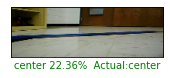

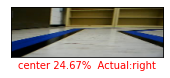

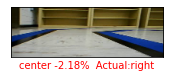

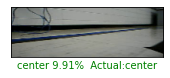

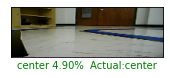

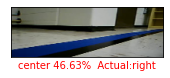

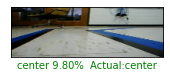

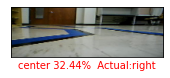

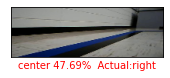

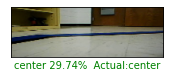

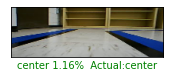

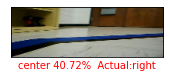

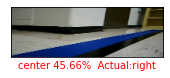

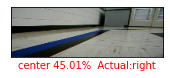

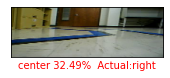

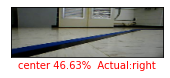

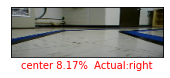

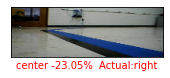

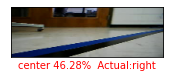

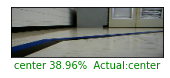

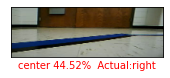

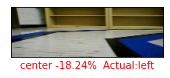

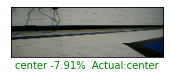

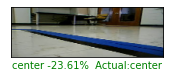

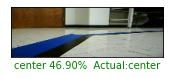

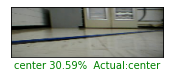

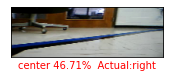

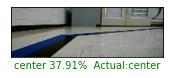

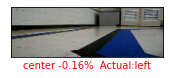

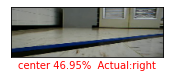

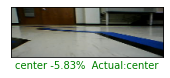

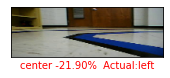

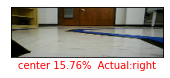

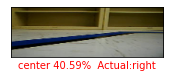

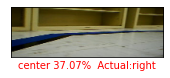

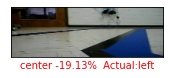

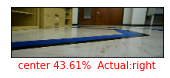

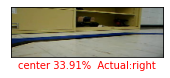

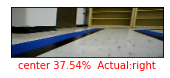

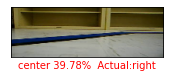

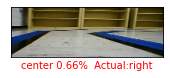

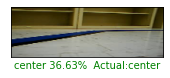

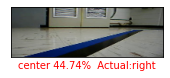

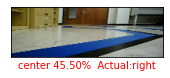

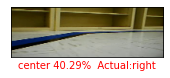

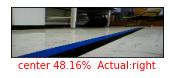

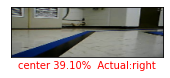

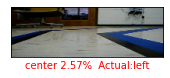

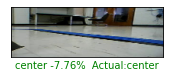

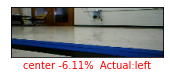

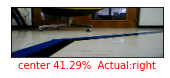

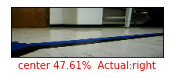

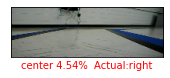

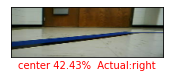

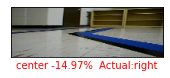

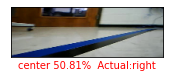

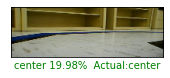

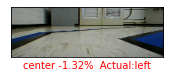

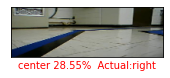

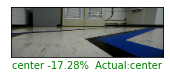

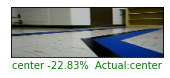

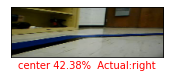

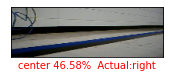

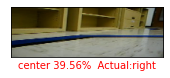

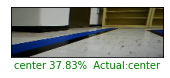

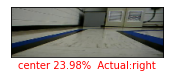

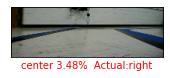

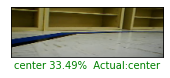

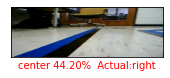

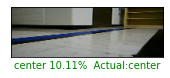

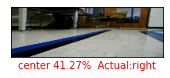

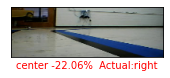

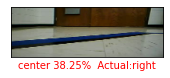

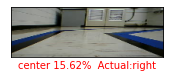

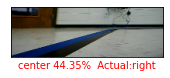

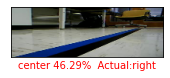

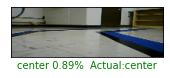

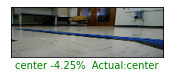

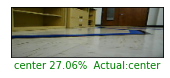

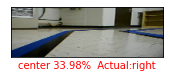

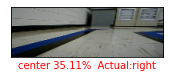

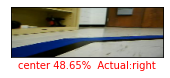

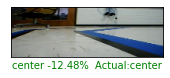

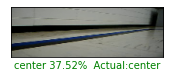

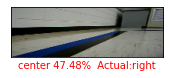

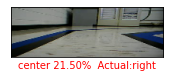

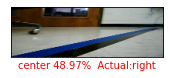

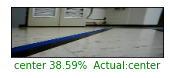

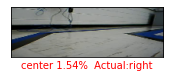

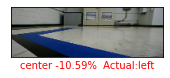

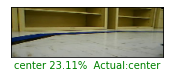

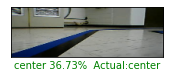

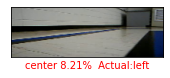

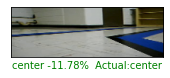

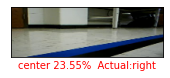

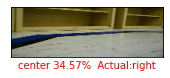

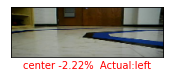

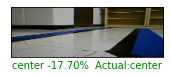

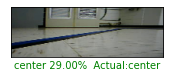

In [ ]:
#@title Visualize the outputs { run: "auto" }
index = 22 #@param {type:"slider", min:0, max:99, step:1}
for index in range(0,99):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, predictions, test_labels, test_imgs)
  plt.show()